# Monte Carlo Estimation of π

## Introduction

In this notebook, we present a basic application of Monte Carlo methods: the estimation of π through random sampling. While the approach is not computationally efficient, it serves as an illustration of how random variables can be employed in statistical estimation.

## Theory

#### The Unit Circle and π

π is defined as the ratio of a circle's circumference to its diameter. For a unit circle (radius = 1), we have:

- **Area of unit circle**: A_circle = πr² = π(1)² = π
- **Area of enclosing square**: A_square = (2r)² = 4

We can divide the area of the unit circle by the area of the square:

`
π/4 = A_circle/A_square
`

which can be rearranged to:

`π = 4 × (A_circle/A_square)`

Hence, we can see that the value of π can be calculated from the two areas.

#### Monte Carlo Principle

Monte Carlo methods use random sampling to solve problems. The key insight is that if we have randomly distributed points which uniformly fill the square, then the ratio of areas is going to be the same as the ratio of points which fall within the unit circle.

For a point (x, y) randomly sampled from the square [-1, 1] × [-1, 1]:
- Point is **inside** unit circle if: x² + y² ≤ 1
- Point is **outside** unit circle if: x² + y² > 1

As the number of samples approaches infinity, the ratio of points inside the circle to total points approaches π/4.

#### Convergence Properties

The Monte Carlo estimate converges to the true value of π with probability 1 (strong law of large numbers). The convergence rate is O(1/√n), meaning:
- To gain 1 decimal place of accuracy, we need ~100× more samples
- Standard error decreases as 1/√n, not 1/n

This relatively slow convergence is a characteristic limitation of this approach. On the other hand Monte Carlo methods can provide uncertainty estimation even in cases when its direct calculation is either impossible or impractical.

In [241]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.patches as patches

In [242]:
def plot_unit_circle(_ax):
    """
    Visualizes the geometric setup for Monte Carlo π estimation.

    The dashed square represents the sample space [-1,1] × [-1,1] from which
    we'll draw random points. The dotted circle represents the region where
    x² + y² ≤ 1, defining points "inside" the unit circle.
    """
    rectangle = patches.Rectangle(
        (-1, -1), 2, 2,
        fill=False,
        color='k',
        alpha=0.7,
        linewidth=1,
        linestyle='--',
        label='Sampling region [-1,1]²'
    )
    _ax.add_patch(rectangle)

    circle = patches.Circle(
        (0, 0), 1,
        fill=False,
        color='k',
        alpha=0.7,
        linewidth=1,
        linestyle='dotted',
        label='Unit circle (r=1)'
    )
    _ax.add_patch(circle)

    _ax.grid(True, alpha=0.3)
    _ax.set_aspect('equal')
    _ax.set_xlim(-1.35, 1.35)
    _ax.set_ylim(-1.35, 1.35)
    _ax.set_xlabel('x')
    _ax.set_ylabel('y')

In [ ]:
class MonteCarloSamples:
    """
    A Monte Carlo sampler for π estimation using geometric probability.

    This class implements the core Monte Carlo algorithm for estimating π by
    generating random points in a square and determining what fraction fall
    within the inscribed unit circle.

    Mathematical Approach
    ---------------------
    1. Generate n random points uniformly distributed in [-1,1] × [-1,1]
    2. For each point (x,y), compute distance from origin: d = √(x² + y²)
    3. Count points where d ≤ 1 (inside unit circle)
    4. Estimate π ≈ 4 × (points_inside / total_points)

    Theoretical Foundation
    ----------------------
    This method relies on the law of large numbers. As n → ∞, the ratio of
    points inside the circle converges to the true ratio of areas π/4.

    The estimate has standard error proportional to 1/√n, meaning:
    - 100 samples: ~1 decimal place accuracy
    - 10,000 samples: ~2 decimal places accuracy  
    - 1,000,000 samples: ~3 decimal places accuracy

    Attributes
    ----------
    _samples : np.ndarray of shape (n_samples, 2)
        Array of random (x, y) coordinates in [-1, 1] × [-1, 1]

    Examples
    --------
    >>> samples = MonteCarloSamples(10000)
    >>> print(f"π estimate: {samples.pi_estimate:.4f}")
    π estimate: 3.1416
    >>> print(f"Used {len(samples)} random samples")
    Used 10000 random samples
    """

    def __init__(self, n_samples: int):
        """
        Initialize Monte Carlo sampler with specified number of random points.

        Parameters
        ----------
        n_samples : int
            Number of random points to generate. Larger values give more
            accurate estimates but require more computation time.
        """
        # Generate n_samples random points in the unit square [-1,1] × [-1,1]
        # np.random.random generates in [0,1), so we scale and shift to [-1,1)
        self._samples = np.random.random((int(n_samples), 2)) * 2 - 1

    def __len__(self) -> int:
        return len(self._samples)

    @property
    def centre_distances(self) -> np.ndarray:
        """
        Compute Euclidean distance from each sample point to the origin.

        Returns
        -------
        np.ndarray of shape (n_samples,)
            Distance d = √(x² + y²) for each point (x, y)
        """
        return np.sqrt((self._samples ** 2).sum(axis=1))

    @property
    def within_unit_circle(self) -> np.ndarray:
        """
        Boolean mask indicating which sample points lie within the unit circle.

        Returns
        -------
        np.ndarray of shape (n_samples,) with dtype bool
            True for points inside unit circle (distance ≤ 1), False otherwise
        """
        return self.centre_distances <= 1

    @property
    def pi_estimate(self) -> float:
        """
        Estimate π using the Monte Carlo method.

        Returns
        -------
        float
            Estimated value of π based on the ratio of points inside the circle

        Algorithm
        ---------
        1. Count points inside unit circle: n_inside = sum(within_unit_circle)
        2. Compute ratio: ratio = n_inside / n_total  
        3. Estimate π: π ≈ 4 × ratio

        Statistical Properties
        ---------------------
        - Unbiased estimator: E[π_estimate] = π
        - Standard error: σ ≈ √(π(4-π)/n) ≈ 1.64/√n
        - 95% confidence interval: π_estimate ± 1.96 × σ

        The factor of 4 comes from the area relationship:
            π = 4 × (circle_area / square_area)
        """
        return float(self.within_unit_circle.sum() / len(self) * 4)

    @property
    def uncertainty_estimate(self) -> float:
        """
        Estimate the standard error of the π estimate using sample statistics.

        Returns
        -------
        float
            Standard error estimate: σ ≈ 4√(p̂(1-p̂)/n)

        Implementation
        -------------
        Uses the sample proportion p̂ to estimate the theoretical standard error
        σ = √(π(4-π)/n). Since π is unknown, we substitute the sample proportion
        p̂ for the theoretical p = π/4, giving σ ≈ 4√(p̂(1-p̂)/n).
        """
        p = self.within_unit_circle.sum() / len(self)
        return float(
            4 * np.sqrt(p * (1 - p) / len(self))
        )

    def plot_samples(self, _ax):
        """
        Visualize the Monte Carlo samples with color-coding
        by circle membership. Samples inside the unit circle
        are shown in blue while orange color shows samples outside.

        Parameters
        ----------
        _ax : matplotlib.axes.Axes
            The matplotlib axes object for plotting
        """
        _is_within_circle = self.within_unit_circle

        _ax.scatter(
            self._samples[_is_within_circle][:, 0],
            self._samples[_is_within_circle][:, 1],
            c='tab:blue',
            alpha=0.6,
            s=10,
            label=f'Inside circle ({_is_within_circle.sum()} points)'
        )

        _ax.scatter(
            self._samples[~_is_within_circle][:, 0],
            self._samples[~_is_within_circle][:, 1],
            c='tab:orange',
            alpha=0.6,
            s=10,
            label=f'Outside circle ({(~_is_within_circle).sum()} points)'
        )

## Experimental Demonstration

### Small Sample Experiment (n = 100)

Let's start with a small sample to see the method in action and understand the inherent variability in Monte Carlo estimates.

In [244]:
samples = MonteCarloSamples(100)

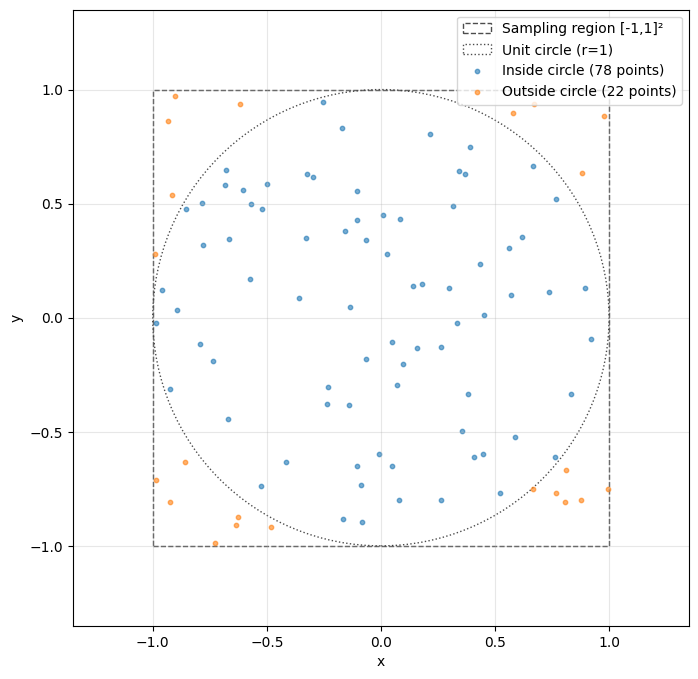

In [245]:
fig, ax = pl.subplots(figsize=(8, 8))

plot_unit_circle(ax)
samples.plot_samples(ax)

ax.legend(loc='upper right')

pl.show()

In [246]:
print(f'Estimated pi value: {samples.pi_estimate:.2f}')

Estimated pi value: 3.12


**Key Observations:**
- We can see the random distribution of points
- With only 100 samples, we expect significant variability in our estimates
- Some clustering is normal due to the random nature of sampling
- The estimate varies significantly from the true value π ≈ 3.14159
- Random sampling naturally introduces variance - this is expected behavior

### Medium Sample Experiment (n = 5,000)

Now let's increase the sample size by 50× to observe improved convergence.

In [247]:
samples = MonteCarloSamples(5000)

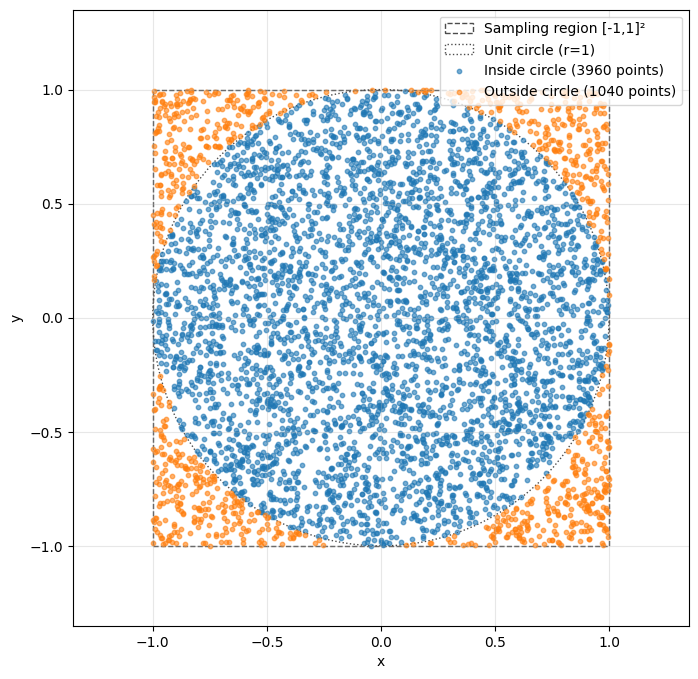

In [248]:
fig, ax = pl.subplots(figsize=(8, 8))

plot_unit_circle(ax)
samples.plot_samples(ax)

ax.legend(loc='upper right')

pl.show()

In [249]:
print(f'Estimated pi value: {samples.pi_estimate:.4f}')

Estimated pi value: 3.1680


In [250]:
samples = MonteCarloSamples(1e7)
print(f'Estimated pi value: {samples.pi_estimate:.4f}')

Estimated pi value: 3.1408


**Key Observations:**
- The estimates get noticeably closer to π ≈ 3.14159 as we increase the sample size
- Visual density increases significantly - the circle boundary becomes clearer

## Error Analysis

A measurement without uncertainty estimation is meaningless - that's what they thought me back at University. To illustrate, consider measuring the weight of a pinch of salt using a personal scale. The display shows 0 kg. Does this imply the salt is weightless? Certainly not. Rather, it indicates that the actual quantity lies below the resolution of the instrument. In this case, the uncertainty of the measurement exceeds the measured value, so the best we can state is that the true weight lies somewhere between 0 and 0.5 kg. This underscores a critical point: without properly reporting measurement uncertainty, we risk drawing incorrect or misleading conclusions.

#### Deriving the Standard Error Formula

The Monte Carlo π estimation can be modeled as a **binomial proportion problem**. Each random point (x, y) can be viewed as a Bernoulli trial:
- **Success**: Point falls inside unit circle (x² + y² ≤ 1)
- **Failure**: Point falls outside unit circle (x² + y² > 1)
- **Success probability**: p = π/4 ≈ 0.7854

With N independent trials, the number of successes X follows the Binomial distribution:
`X ~ Binomial(N, p) where p = π/4`

which has the following properties:

- **Mean**: `E[X] = Np = N(π/4)`
- **Variance**: `Var(X) = Np(1-p) = N(π/4)(1-π/4) = N(π/4)(4-π)/4`

Given our estimator is the sample proportion `p̂ = X/n` we can derive:

- **Mean**: `E[p̂] = E[X/N] = E[X]/N = Np/N = p = π/4`
- **Variance**: `Var(p̂) = Var(X/N) = Var(X)/N² = Np(1-p)/N² = p(1-p)/N`

Since π̂ = 4p̂, we have:

- **Mean**: `E[π̂] = E[4p̂] = 4 * π/4 = π`
- **Variance**: `Var(π̂) = Var(4p̂) = 16·Var(p̂) = 16·p(1-p)/N`

Now our uncertainty (standard deviation) estimate would be:

`σ = √Var(π̂) = √(16·p̂(1-p̂)/N) = 4·√(p̂(1-p̂)/N)`

Let's now use this derived formula to add uncertainties to our estimates.

In [306]:
sample_sizes, estimates, uncertainties = [], [], []
for order in range(20, 60):
    sample_size = 10 ** (order / 10)
    samples = MonteCarloSamples(sample_size)

    sample_sizes.append(sample_size)
    estimates.append(samples.pi_estimate)
    uncertainties.append(samples.uncertainty_estimate)

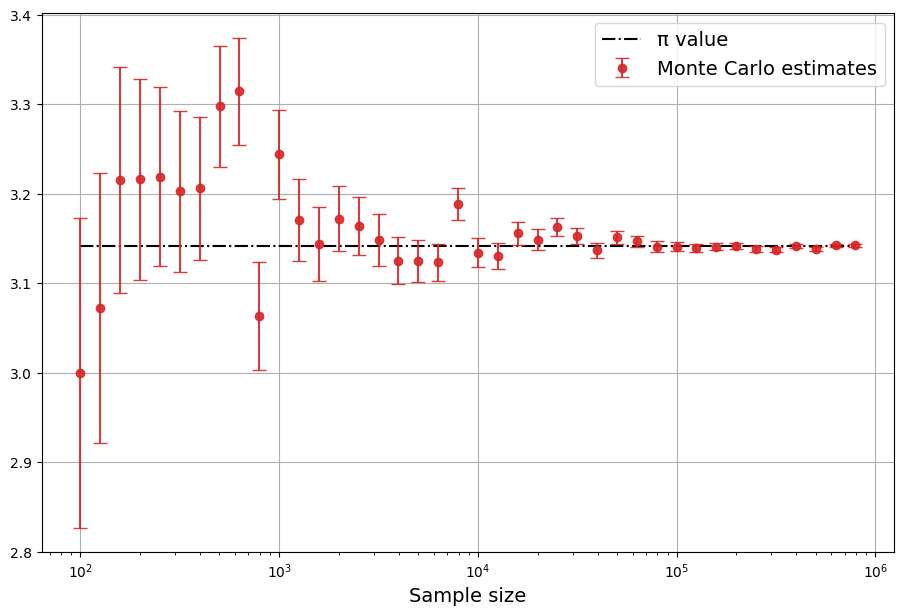

In [307]:
pl.figure(figsize=(11, 7))
pl.plot(
    sample_sizes,
    [np.pi] * len(sample_sizes),
    '-.',
    color='k',
    label='π value'
)
pl.errorbar(
    sample_sizes,
    estimates,
    yerr=uncertainties,
    capsize=5,
    alpha=0.9,
    fmt='o',
    color='tab:red',
    ecolor='tab:red',
    label='Monte Carlo estimates'
)
pl.xscale('log')
pl.grid(True)
pl.legend(fontsize=14)
pl.xlabel('Sample size', fontsize=14)
pl.show()

## Conclusions and Extensions

### Key Takeaways

1. **Monte Carlo Convergence**: The method converges to π, demonstrating the law of large numbers in action

2. **Statistical Trade-offs**: Accuracy improves as O(1/√n), making high precision computationally expensive

3. **Uncertainty Quantification**:

    - We can estimate our estimation error using `σ ≈ 4√(p̂(1-p̂)/N)`, providing confidence bounds for our results
    - The `uncertainty_estimate` method shows that even when the true parameter (π) is unknown, we can still estimate our uncertainty using sample-based approximations

### Computational Complexity

- **Time Complexity**: O(n) for generating and classifying n random points
- **Space Complexity**: O(n) for storing the sample coordinates
- **Scalability**: Method scales linearly with desired sample size
- **Error Calculation**: O(1) additional cost for uncertainty estimation

### Real-World Applications

- **Physics**: Particle simulations, quantum mechanics
- **Finance**: Option pricing, risk analysis  
- **Engineering**: Reliability analysis, optimization
- **Machine Learning**: Bayesian inference, reinforcement learning

The principles demonstrated here—random sampling, statistical estimation, uncertainty quantification, and convergence analysis—form the foundation for these advanced applications. The ability to estimate both the value and its uncertainty is particularly useful in scientific computing and data analysis.